# Intro

=================================================

   

   Nama  : Dery Rai Ambhara
   

   Program ini dirancang untuk menganalisis dataset 'Indonesian Sentiment Twitter Dataset Labeled.csv' yang berasal dari platform Kaggle. Dalam proses pengolahan data, digunakan konsep klasifikasi dengan memanfaatkan Neural Network Architecture (NNA), Natural Language Processing (NLP), serta metode Gated Recurrent Unit (GRU) dan Long Short-Term Memory (LSTM). Tujuannya adalah untuk memprediksi apakah tweet tersebut mengandung kata-kata dengan sentimen negatif, positif, atau netral.

=================================================

# Library

In [ ]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as tf_hub

from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report

!pip install pysastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data Loading

' Source: https://www.kaggle.com/datasets/bondanvitto/indonesia-twitter-comment-labeled-with-ite-law '

In [ ]:
# Data Loading

df = pd.read_csv('/content/Dataset Twitter Fix - Indonesian Sentiment Twitter Dataset Labeled (1).csv',header=None).rename({0:'sentimen',1:'text'},axis=1)
df

,sentimen,text
0,0.0,barusan liat tulisan di belakang truk rela inj...
1,0.0,her itu lho miss kevin sama keven rebutan gimb...
2,0.0,iya rep gatau aku masih kelas 4 sd ehh di block
3,0.0,aku mohon tepatilah janjimu penantiancintaeps19
4,0.0,bukan beria nk kahwin sbb gatal celah kangkang...
...,...,...
12642,6.0,"Jangan dibahas dong, udah paham aja kan di kau..."
12643,6.0,di agama lo nyembah nya siapa sih? masa Tuhan ...
12644,6.0,"Katanya demi kemanusiaan, kemanusiaan milik ma..."
12645,6.0,Orang timur kurang pintar dari orang barat


**Insight**: Data yang tertampil merupakandata dari dataset. Jika dilihat dari dataset yang ditampilkan, terdapat 3 kolom dataset yang berisikan informasi

# Text Preprocessing

In [ ]:
# Define Stopwords
from nltk.corpus import stopwords
stpwds_id = list(set(stopwords.words('indonesian')))
stpwds_id.append('oh') # Cara lain dari "stpwds_id = stpwds_id + ['oh']"

# Define Stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
stemmer = StemmerFactory().create_stemmer()

**Insight** : menyiapkan daftar stopwords dalam bahasa Indonesia dan objek stemmer untuk analisis teks dalam konteks bahasa Indonesia.

In [ ]:
# Create A Function for Text Preprocessing

def text_preprocessing(text):
  # Case folding
  text = text.lower()

  # Mention removal
  text = re.sub("@[A-Za-z0-9_]+", " ", text)

  # Hashtags removal
  text = re.sub("#[A-Za-z0-9_]+", " ", text)

  # Newline removal (\n)
  text = re.sub(r"\\n", " ",text)

  # Whitespace removal
  text = text.strip()

  # URL removal
  text = re.sub(r"http\S+", " ", text)
  text = re.sub(r"www.\S+", " ", text)

  # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
  text = re.sub("[^A-Za-z\s']", " ", text)

  # Tokenization
  tokens = word_tokenize(text)

  # Stopwords removal
  tokens = [word for word in tokens if word not in stpwds_id]

  # Stemming
  tokens = [stemmer.stem(word) for word in tokens]

  # Combining Tokens
  text = ' '.join(tokens)

  return text

 **Insight** : implementasi fungsi pra-pemrosesan teks dalam bahasa Inggris, yang fungsinya untuk melakukan pengubahan huruf kecil, penghapusan mention, hashtags, newline, whitespace, URL, karakter non-huruf, tokenisasi, penghapusan stopwords, dan stemming, tujuannya untuk membersihkan dan mempersiapkan text untuk dianalisa lebih lanjut.

In [ ]:
# Applying Text Preprocessing to the dfset

df['text_processed'] = df['text'].apply(lambda x: text_preprocessing(x))
df

,sentimen,text,text_processed
0,0.0,barusan liat tulisan di belakang truk rela inj...,barusan liat tulis truk rela injek kopling sho...
1,0.0,her itu lho miss kevin sama keven rebutan gimb...,her lho miss kevin keven rebut gimbot ya wis b...
2,0.0,iya rep gatau aku masih kelas 4 sd ehh di block,iya rep gatau kelas sd ehh block
3,0.0,aku mohon tepatilah janjimu penantiancintaeps19,mohon tepat janji penantiancintaeps
4,0.0,bukan beria nk kahwin sbb gatal celah kangkang...,ria nk kahwin sbb gatal celah kangkang tp pena...
...,...,...,...
12642,6.0,"Jangan dibahas dong, udah paham aja kan di kau...",bahas udah paham aja kaum kayak gitu udah gak ...
12643,6.0,di agama lo nyembah nya siapa sih? masa Tuhan ...,agama lo nyembah nya sih tuhan lahir kandang d...
12644,6.0,"Katanya demi kemanusiaan, kemanusiaan milik ma...",manusia manusia milik mayoritas mksdnya
12645,6.0,Orang timur kurang pintar dari orang barat,orang timur pintar orang barat


**Insight** : pra-pemrosesan `teks` (text_preprocessing) pada kolom 'text'. hasilnya akan disimpan pada column baru bernama `text_processed`. langkah ini merupakan proses untuk mempersiapkan analisis lebih lanjut.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12647 entries, 0 to 12646
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sentimen        12646 non-null  float64
 1   text            12647 non-null  object 
 2   text_processed  12647 non-null  object 
dtypes: float64(1), object(2)
memory usage: 296.5+ KB


**Insight** : Ditemukan data null sebanyak 1, dan kemudian akan dilakukan proses drop pada data null

In [ ]:
# Hapus baris yang mengandung NaN di kolom
df=df.dropna(subset=['sentimen'])

**Insigt** : data null sudah dihapus

# EDA

<Axes: xlabel='sentimen'>

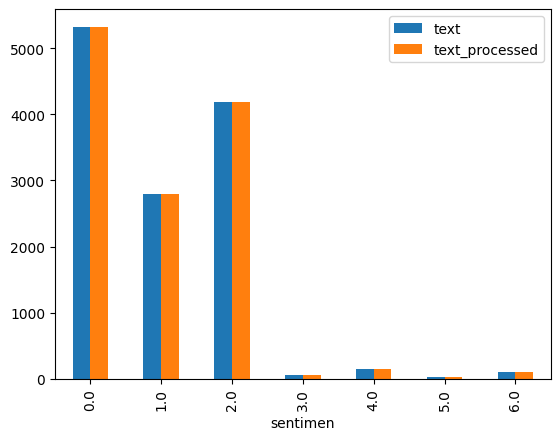

In [ ]:
# The distribution of sentiments
df.groupby('sentimen').count().plot(kind='bar')

**Insight** : Menurut data diatas. data dengan sentimen 0.0 (Neutral) memiliki jumlah paling banyak dibandingkan sentimen lainnya

<ipython-input-9-4d3f14639403>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['length'] = df.text_processed.str.split().apply(len)


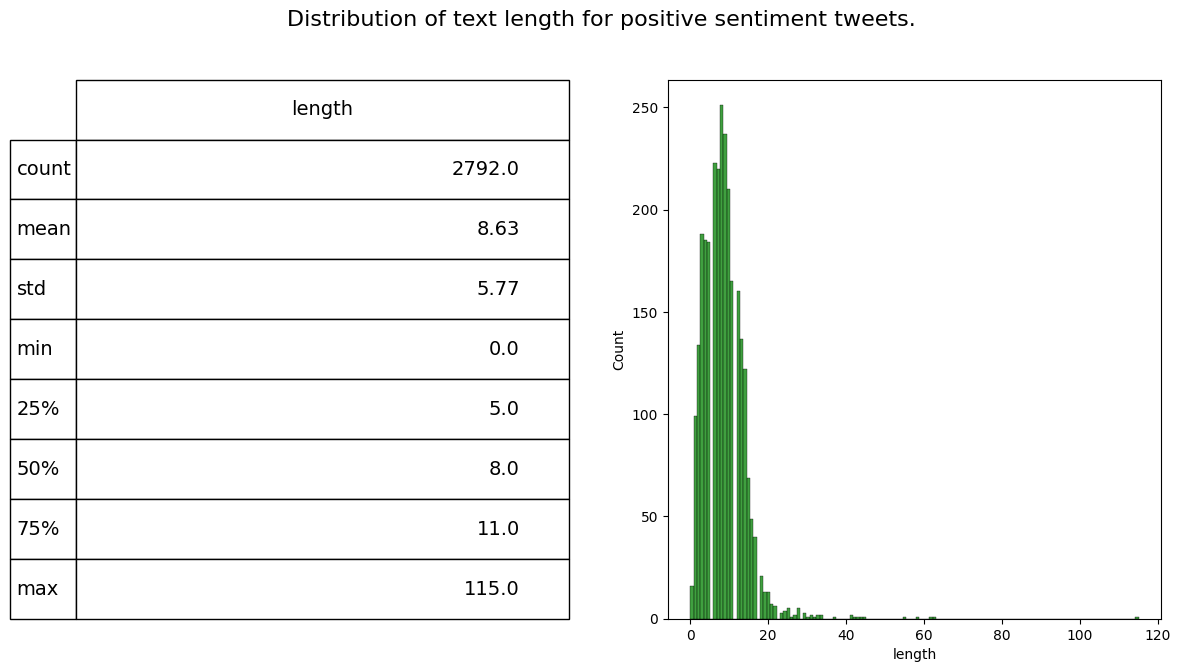

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.text_processed.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['sentimen']==1]['length'], ax=ax1,color='green')
describe = df.length[df.sentimen==1].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

**Insight** : Berikut merupakan visualisasi tentang panjang teks dalam tweet yang memiliki sentimen positif. visualisasi ini menunjukkan Pemahaman tentang panjang rata-rata dapat memberikan wawasan tentang seberapa panjang atau pendek tweet yang umumnya dikaitkan dengan sentimen positif. pada sentimen positive, memiliki rata rata panjang kata sebesar `8.63` kata dengan minimal kata berada di `0` kata dan maksimal berada di `115` kata. Dengan melihat distribusi panjang kata, Apakah mayoritas tweet positif cenderung pendek, panjang, atau justru to the point jika dibandingkan dengan rata rata dengan sentimen negative ataupun neutral.

<ipython-input-10-436ae41a2e39>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['length'] = df.text_processed.str.split().apply(len)


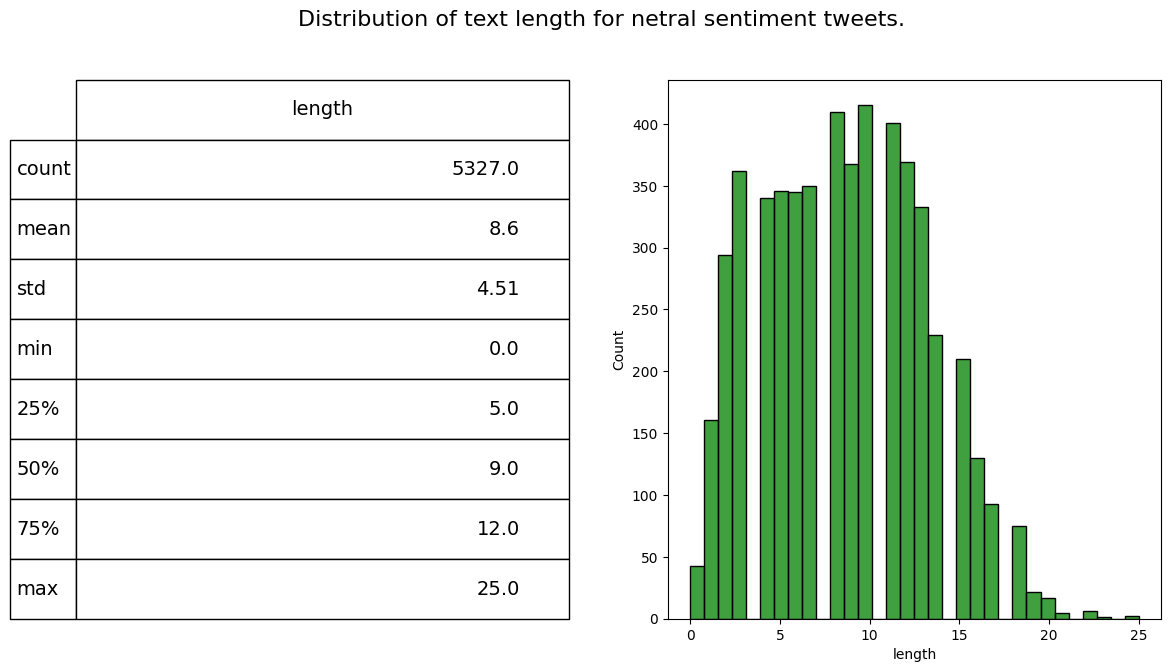

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.text_processed.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['sentimen']==0]['length'], ax=ax1,color='green')
describe = df.length[df.sentimen==0].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for netral sentiment tweets.', fontsize=16)

plt.show()

**Insight** : Berikut merupakan visualisasi tentang panjang teks dalam tweet yang memiliki sentimen neutral. visualisasi ini menunjukkan Pemahaman tentang panjang rata-rata dapat memberikan wawasan tentang seberapa panjang atau pendek tweet yang umumnya dikaitkan dengan sentimen neutral. pada sentimen neutral, memiliki rata rata panjang kata sebesar `8.6` kata dengan minimal kata berada di `0` kata dan maksimal berada di `25` kata. Dengan melihat distribusi panjang kata, Apakah mayoritas tweet neutral cenderung pendek, panjang, atau justru to the point jika dibandingkan dengan rata rata dengan sentimen negative ataupun positif. jika dibandingkan data positive dan negative panjang rata rata kata neutral cenderung lebih pendek jika dibandingkan dengan kedua sentimen positive dan negative.

<ipython-input-11-c48fb4869d2f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['length'] = df.text_processed.str.split().apply(len)


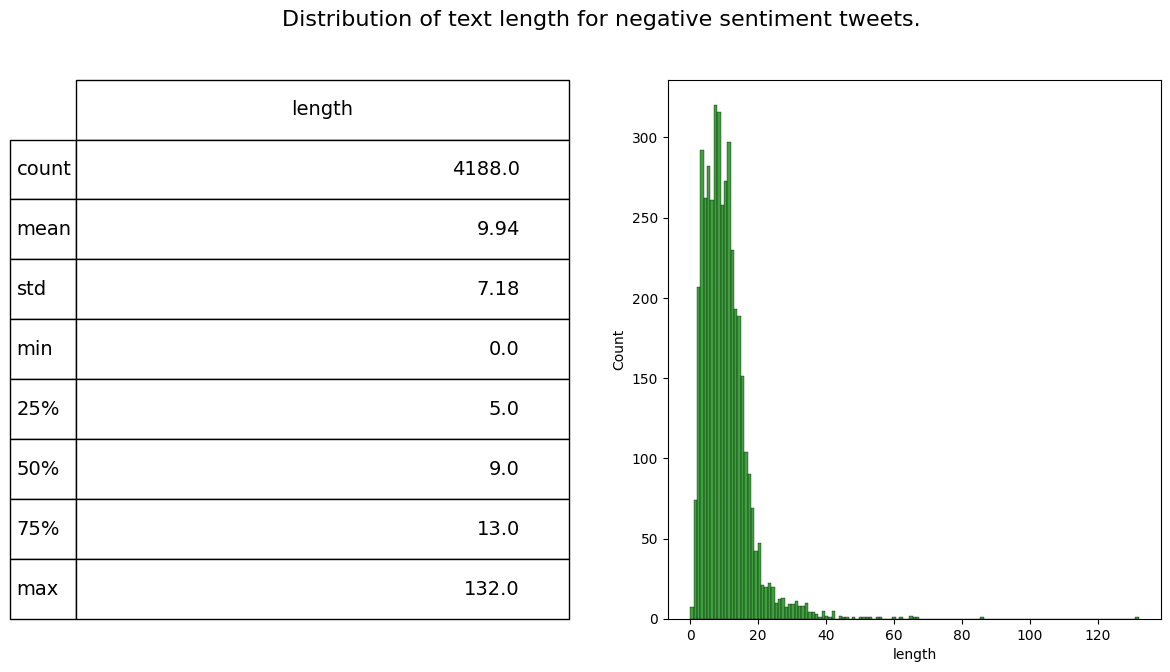

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.text_processed.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['sentimen']==2]['length'], ax=ax1,color='green')
describe = df.length[df.sentimen==2].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for negative sentiment tweets.', fontsize=16)

plt.show()

**Insight** : Berikut merupakan visualisasi tentang panjang teks dalam tweet yang memiliki sentimen negative. visualisasi ini menunjukkan Pemahaman tentang panjang rata-rata dapat memberikan wawasan tentang seberapa panjang atau pendek tweet yang umumnya dikaitkan dengan sentimen negative. pada sentimen negative, memiliki rata rata panjang kata sebesar `9.94` kata dengan minimal kata berada di `0` kata dan maksimal berada di `132` kata. Dengan melihat distribusi panjang kata, Apakah mayoritas tweet negative cenderung pendek, panjang, atau justru to the point jika dibandingkan dengan rata rata dengan sentimen positif ataupun neutral. jika dibandingkan data positive, panjang rata rata kata negative hampir sama dengan rata rata panjang kata positive.

<ipython-input-12-bd956d38d83c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['length'] = df.text_processed.str.split().apply(len)


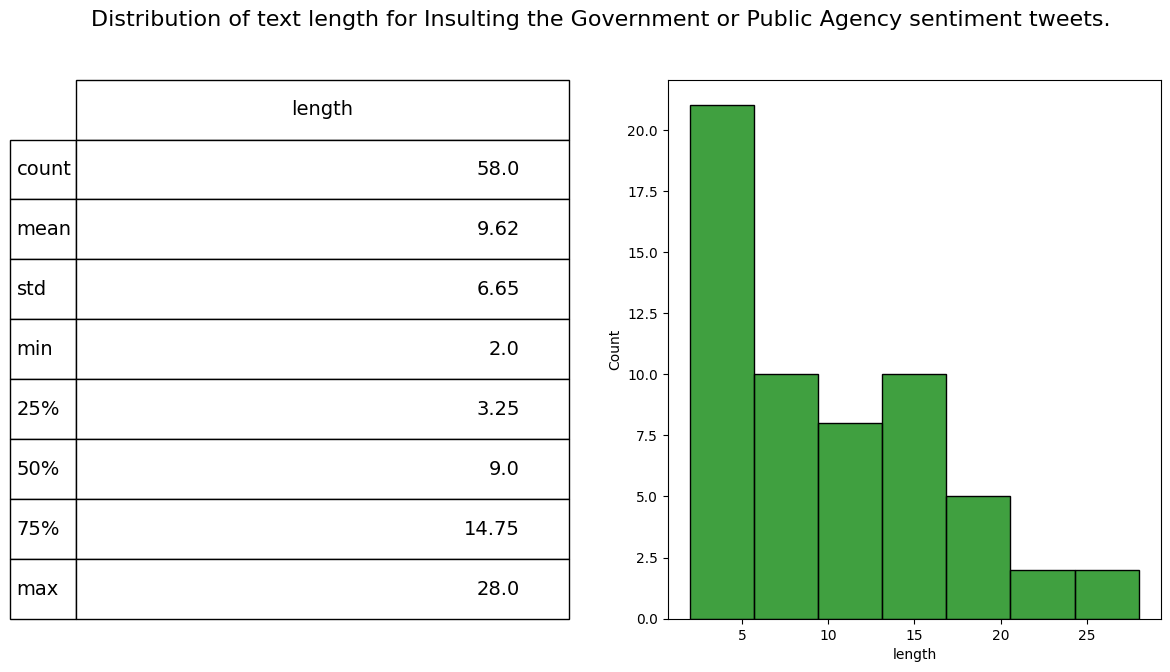

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.text_processed.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['sentimen']==3]['length'], ax=ax1,color='green')
describe = df.length[df.sentimen==3].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Insulting the Government or Public Agency sentiment tweets.', fontsize=16)

plt.show()

**Insight** : Berikut merupakan visualisasi tentang panjang teks dalam tweet yang memiliki sentimen Insulting The Government or Public Agency. visualisasi ini menunjukkan Pemahaman tentang panjang rata-rata dapat memberikan wawasan tentang seberapa panjang atau pendek tweet yang umumnya dikaitkan dengan sentimen Insulting The Government or Public Agency. pada sentimen Insulting The Government or Public Agency, memiliki rata rata panjang kata sebesar `9.62` kata dengan minimal kata berada di `0` kata dan maksimal berada di `28` kata.

<ipython-input-13-80933186ab61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['length'] = df.text_processed.str.split().apply(len)


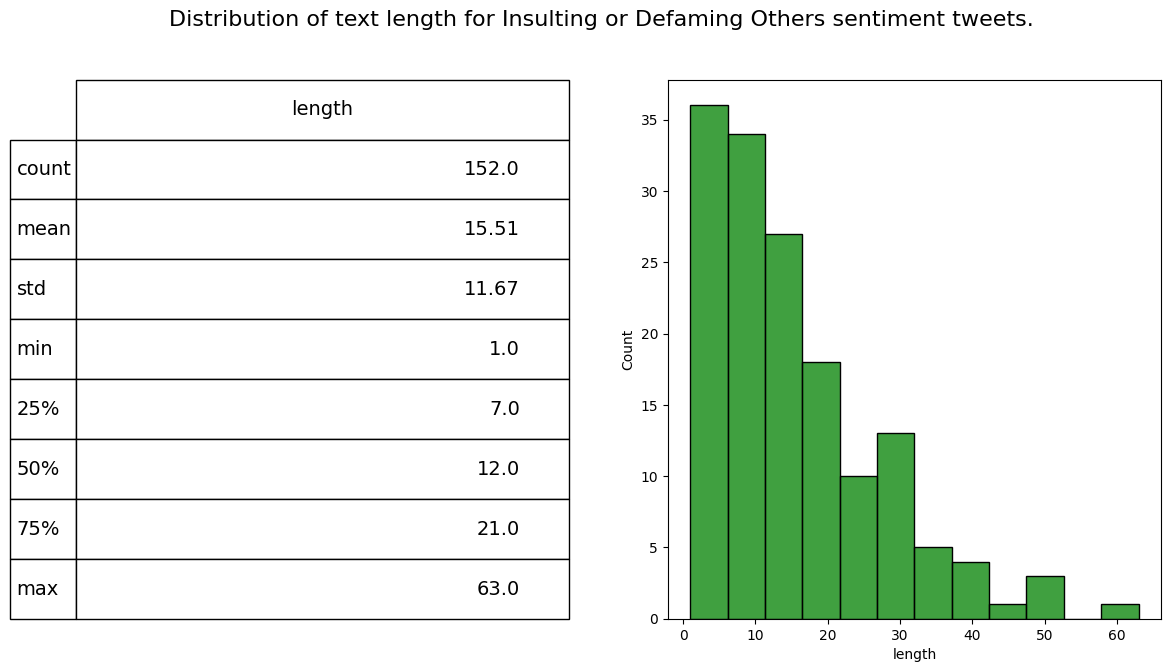

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.text_processed.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['sentimen']==4]['length'], ax=ax1,color='green')
describe = df.length[df.sentimen==4].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Insulting or Defaming Others sentiment tweets.', fontsize=16)

plt.show()

**Insight** : Berikut merupakan visualisasi tentang panjang teks dalam tweet yang memiliki sentimen Insulting or Defaming Others. visualisasi ini menunjukkan Pemahaman tentang panjang rata-rata dapat memberikan wawasan tentang seberapa panjang atau pendek tweet yang umumnya dikaitkan dengan sentimen Insulting or Defaming Others. pada sentimen Insulting or Defaming Others, memiliki rata rata panjang kata sebesar `15.51` kata dengan minimal kata berada di `0` kata dan maksimal berada di `63` kata.

<ipython-input-14-04535a530476>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['length'] = df.text_processed.str.split().apply(len)


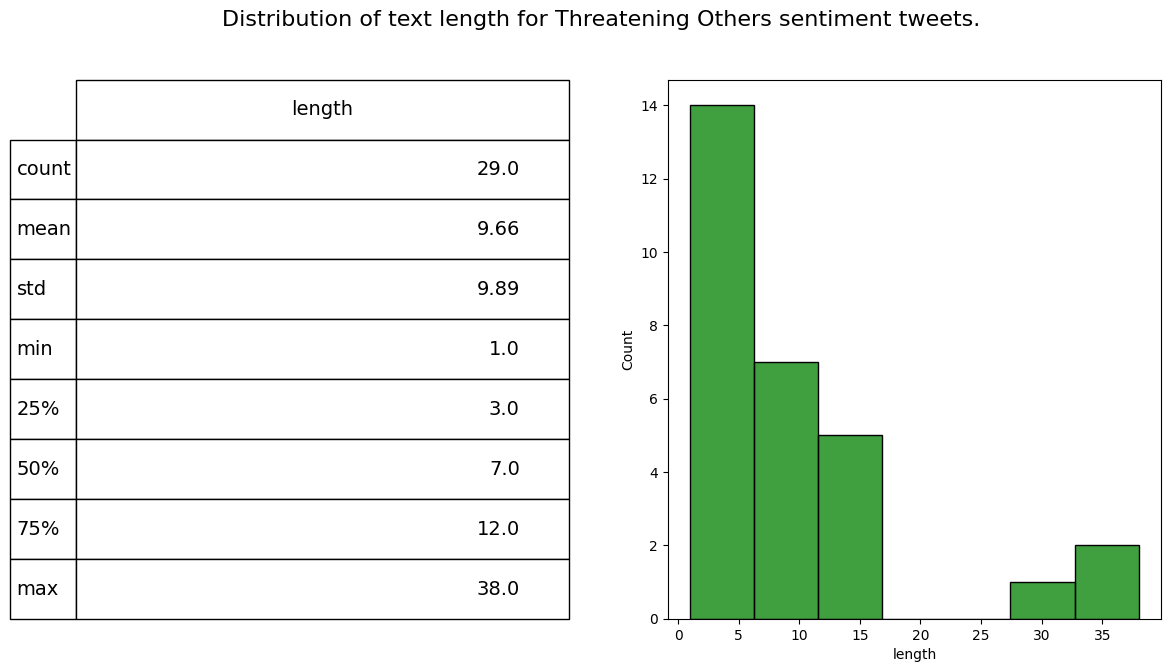

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.text_processed.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['sentimen']==5]['length'], ax=ax1,color='green')
describe = df.length[df.sentimen==5].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Threatening Others sentiment tweets.', fontsize=16)

plt.show()

**Insight** : Berikut merupakan visualisasi tentang panjang teks dalam tweet yang memiliki sentimen Threatening Others. visualisasi ini menunjukkan Pemahaman tentang panjang rata-rata dapat memberikan wawasan tentang seberapa panjang atau pendek tweet yang umumnya dikaitkan dengan sentimen Threatening Others. pada sentimen Threatening Others, memiliki rata rata panjang kata sebesar `9.66` kata dengan minimal kata berada di `1` kata dan maksimal berada di `38` kata.

<ipython-input-15-ead279f664b1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['length'] = df.text_processed.str.split().apply(len)


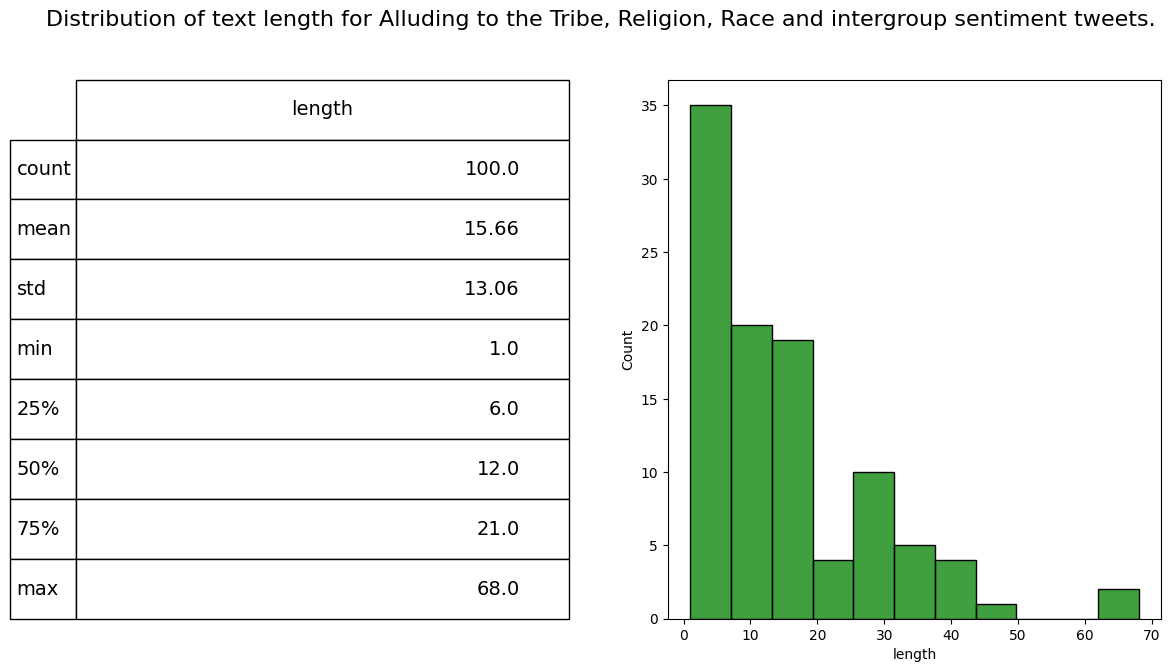

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.text_processed.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['sentimen']==6]['length'], ax=ax1,color='green')
describe = df.length[df.sentimen==6].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Alluding to the Tribe, Religion, Race and intergroup sentiment tweets.', fontsize=16)

plt.show()

**Insight** : Berikut merupakan visualisasi tentang panjang teks dalam tweet yang memiliki sentimen Alluding to the Tribe,Relligion,Race and intergroup . visualisasi ini menunjukkan Pemahaman tentang panjang rata-rata dapat memberikan wawasan tentang seberapa panjang atau pendek tweet yang umumnya dikaitkan dengan sentimen Alluding to the Tribe,Relligion,Race and intergroup . pada sentimen Alluding to the Tribe,Relligion,Race and intergroup , memiliki rata rata panjang kata sebesar `15.66` kata dengan minimal kata berada di `1` kata dan maksimal berada di `68` kata.

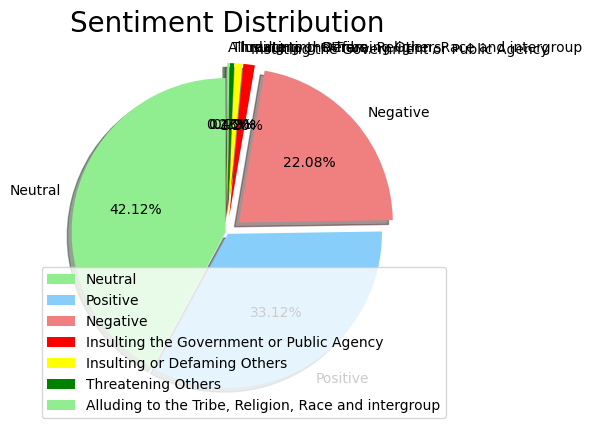

In [ ]:
labels = ['Neutral', 'Positive', 'Negative','Insulting the Government or Public Agency','Insulting or Defaming Others','Threatening Others','Alluding to the Tribe, Religion, Race and intergroup']
size = df['sentimen'].value_counts()
colors = ['lightgreen', 'lightskyblue', 'lightcoral','red','yellow','green']
explode = [0.01, 0.01, 0.1,0.1,0.1,0.1,0.1]

fig, axes = plt.subplots(figsize=(6, 5))
plt.pie(size, colors = colors, explode = explode,
        labels = labels, shadow = True, startangle = 90, autopct = '%.2f%%')
plt.title('Sentiment Distribution', fontsize = 20)
plt.legend()
plt.show()

**Insight** :

Berdasarkan visualisasi distribusi sentimen, terlihat bahwa jumlah data dengan sentimen "Netral" mendominasi sebesar 42.12%, sedangkan jumlah data dengan sentimen "Positif" sebesar 33.12%, dan sentimen "Negatif" sebesar 22.08% dan sisanya dibawah 1% dari keseluruhan data  Dengan kata lain, kategori "Netral" memiliki jumlah data yang lebih besar dibandingkan dengan sentimen lainnya

# Target Conversion

In [ ]:
# Display Target

df.sentimen.unique()

array([0., 1., 2., 4., 6., 3., 5.])

In [ ]:
# Target Distribution

df['sentimen'].value_counts()

,count
sentimen,
0.0,5327
2.0,4188
1.0,2792
4.0,152
6.0,100
3.0,58
5.0,29


In [ ]:
# df Splitting

X_train_val, X_test, y_train_val, y_test = train_test_split(df.text_processed,
                                                    df.sentimen,
                                                    test_size=0.15,
                                                    random_state=20,
                                                    stratify=df.sentimen)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=20,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (9674,)
Val Size   :  (1075,)
Test Size  :  (1897,)


**Insight** : Proses pemisahan dataset (data splitting) menjadi bagian-bagian yang berbeda untuk keperluan pelatihan (training), validasi, dan pengujian (testing) menggunakan fungsi `train_test_split`.

- Train Size : (`9674`,), pelatihan ini memiliki 9674 sampel data.
- Val Size : (`1075`,), Dataset validasi memiliki 1075 sampel untuk mengevaluasi performa model di setiap epoch dan membantu menghindari overfitting
- Test Size : (`1897`,), Dataset pengujian memiliki 1897sampel. test size tidak digunakan pada pelatihan model, namun test size ini akan digunakan pada saat mengevaluasi data yang belum pernah dilihat sebelumnya.
- Parameter:
    - test_size=0.15 yang artinya melakukan pemisahan antara data pelatihan dan data pengujian, sebanyak 15% dari keseluruhan data digunakan untuk data pengujian.
    - test_size=0.10 yang artinya sebanyak 10% dari data pelatihan dan validasi digunakan sebagai data validasi.
    - random_state=20 yang artinya ketika menjalankan kembali kode dengan parameter yang sama, hasil pemisahan dataset bisa konsisten atau sama seperti sebelumnya.
    - stratify= proporsi jumlah kategori atau label pada setiap bagian (pelatihan, validasi, dan pengujian) tetap serupa dengan proporsi kategori pada keseluruhan dataset. Hal ini bertujuan untuk mencegah adanya kecenderungan atau bias terhadap suatu kategori tertentu di salah satu bagian dataset.

In [ ]:
# Change Target to One Hot Encoding

from tensorflow.keras.utils import to_categorical

y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Model Building

## C.4.1 - Text Vectorization

In [ ]:
# Get Vocabularies

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<9674x16762 sparse matrix of type '<class 'numpy.int64'>'
	with 80248 stored elements in Compressed Sparse Row format>

**Insight**:

- CountVectorizer adalah untuk mengonversi teks menjadi representasi vektor berdasarkan frekuensi kemunculan kata (bag of words). Vectorize akan dipasangkan dengan metode fit_transform(X_train), di mana X_train adalah dataset teks pelatihan. Ini akan membangun kosakata (vocabulary) berdasarkan kata-kata yang muncul dalam dataset pelatihan dan mengonversi teks menjadi vektor berdasarkan frekuensi kemunculan kata-kata tersebut.

    - Matriks tersebut memiliki ukuran 9674x16762, yang berarti terdapat 9674 sampel dalam dataset pelatihan dan 16762 kata unik dalam kosakata (vocabulary) dengan Tipe matriks ini adalah "sparse matrix".
    - `80248` yang artinya terdapat elemen yang tersimpan dalam matriks sparse.

In [ ]:
# Finding the Number of Vocabs and Max Token Length in One Document

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  16762
Maximum Sentence Length :  133 tokens


**Insight** :

memiliki Total Vocab sebanyak 16762 kata unik, dan panjang Maximum Sentence Length adalah 133 kata. Informasi ini dapat digunakan untuk menyesuaikan parameter atau memahami karakteristik dataset sebelum melibatkan model pembelajaran mesin pada tugas tertentu.

In [ ]:
# Text Vectorization

from tensorflow.keras.layers import TextVectorization

text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train)

**Insight** :

Menggunakan TextVectorization untuk mengonversi teks ke dalam representasi vektor yang dapat digunakan oleh model neural network.
- Mempersiapkan pengolahan teks yang siap digunakan untuk model pembelajaran mesin dengan parameter yang sesuai dengan dataset pelatihan. dengan menggunakan parameter max_tokens, standardize, split, ngrams,output_mode, output_sequence_length.
- `adapt`, method ini untuk menyesuaikan TextVectorization dengan dataset X_train.


In [ ]:
# Example Result

## Document example
print('Document example')
print(df.text_processed[0])
print('')

## Result of Text Vectorization
print('Result of Text Vectorization')
print(text_vectorization([df.text_processed[0]]))
print('Vector size : ', text_vectorization([df.text_processed[0]]).shape)

Document example
barusan liat tulis truk rela injek kopling shopping

Result of Text Vectorization
tf.Tensor(
[[2409   56  215 2964 1255    1    1 5108    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]], shape=(1, 133), dtype=int64)
Vector size :  (1, 133)


**Insight** :

- Dengan menggunakan TextVectorization, contoh dokumen teks (barusan liat tulis truk rela injek kopling shopping) dapat diubah menjadi representasi vektor bilangan bulat yang dapat digunakan sebagai input untuk model pembelajaran mesin.

In [ ]:
# View the Top 20 Tokens (Sorted by the Highest Frequency of Appearance)

text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'yg',
 'x',
 'orang',
 'ya',
 'ni',
 'nak',
 'aja',
 'ga',
 'gak',
 'kau',
 'tu',
 'kalo',
 'nya',
 'suka',
 'dah',
 'f',
 'xf',
 'tau']

**Insight** : berikut merupakan `get_vocabulary` dari `TextVectorization`, mencakup nilai token kosong, ataupun nilai yang tidak dikenal [UNK], dan beberapa kata lainnya.

## C.4.2 - Word Embedding

In [ ]:
# Embedding

from tensorflow.keras.layers import Embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

**Insight** :

Menggunakan layer Embedding, untuk membuat lapisan embedding kata pada model neural network. berikut penjelasan terkait konfirgurasi dari Embedding Layer :
1. input_dim = Jumlah kata dalam kosakata yang akan di-embedding
2. output_dim = Dimensi output embedding untuk setiap kata
3. embeddings_initializer = Inisialisasi bobot embedding
4. input_length= Panjang maksimum dari setiap dokumen (dalam kata)

Layer ini dirancang untuk mengubah kata-kata dalam teks menjadi representasi vektor angka kontinu

In [ ]:
# Example Result

## Document example
print('Document example')
print(df.text_processed[0])
print('')

## Result of Text Vectorization
print('Result of  Text Vectorization')
print(text_vectorization([df.text_processed[0]]))
print('Vector size : ', text_vectorization([df.text_processed[0]]).shape)
print('')

## Result of  Embedding
print('Result of  Embedding')
print(embedding(text_vectorization([df.text_processed[0]])))
print('Vector size : ', embedding(text_vectorization([df.text_processed[0]])).shape)

Document example
barusan liat tulis truk rela injek kopling shopping

Result of  Text Vectorization
tf.Tensor(
[[2409   56  215 2964 1255    1    1 5108    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]], shape=(1, 133), dtype=int64)
Vector size :  (1, 133)

Result of  Embedding
tf.Tensor(
[[[-0.02976253  0.04821267 -0.00527734 ...  0.03869286 -0.04781317
    0.03961852]
  [-0.01377656  0.02987665  0.01

**Insight** :

Output menghasilkan bagaimana teks "barusan liat tulis truk rela injek kopling shopping." diubah menjadi representasi numerik dengan dua langkah:
1. menggunakan TextVectorization untuk mendapatkan vektor bilangan bulat.
2. menggunakan layer Embedding untuk mengonversi vektor tersebut menjadi representasi vektor kontinu dengan dimensi 128.

## C.4.3 - LSTM

In [ ]:
# Redefine the TextVectorization layer with the correct output_mode
text_vectorization = TextVectorization(output_mode='int', max_tokens=20000, output_sequence_length=200)


In [ ]:
# Fit the TextVectorization layer to the training data
text_vectorization.adapt(X_train)


In [ ]:
# Model Training using LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape, Input
from tensorflow.keras.callbacks import EarlyStopping

callbacks_1= [
    EarlyStopping(monitor='val_loss', patience= 5, restore_best_weights=True)
]

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
# Define an Input layer to specify the shape
input_layer = Input(shape=(1,), dtype=tf.string)
# Apply the text_vectorization layer to the input
vectorized_text = text_vectorization(input_layer)
# Apply the embedding layer to the vectorized text
embedded_text = embedding(vectorized_text)
# Create the rest of the model
x = Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed)))(embedded_text)
x = Dropout(0.1)(x)
x = Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed)))(x)
x = Dropout(0.1)(x)
output_layer = Dense(7, activation='softmax')(x)

# Create the model
model_lstm_1 = tf.keras.Model(inputs=input_layer, outputs=output_layer)

model_lstm_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 200)               0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 200, 128)          2145536   
                                                                 
 bidirectional (Bidirection  (None, 200, 64)           41216     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 200, 64)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368 

**Insight** :

Berikut merupakan sebuah model neural network menggunakan (Long Short-Term Memory), berikut sedikit penjelasan terkait  arsitektur model yang dibuat.

- Clear Session : Dilakukan pembersihan `tf.keras.backend.clear_session()` untuk memastikan konsistensi dari sebuah model. lalu seed diatur untuk memastikan hasil pelatihan yang di reproduksi. seed merupakan nilai awal yang digunakan untuk menginisialisasi generator angka acak.
- Arsitektur Model :
    - Model Menggunakan Sequential untuk menentukan urutan layer.
    - layer pertama adalah `text_vectorization` yang sudah dibangun sebelumnya untuk mengkonversi sebuah text menjadi representasi vektor.
    - Lalu dilayer kedua adalah `Embedding` yang mengubah vektor angka dengan dimensi 128
    - lalu 2 layer dengan LSTM dengan arah `Bidirectional` dengan ukuran 32 dan 16. `Bidirectional` yang dimaksud disini adalah untuk pemrosesan urutan dalam dua arah, yang dapat membantu model dalam memahami konteks teks dengan lebih baik.
    - lalu menggunakan `Dropout` untuk menghindari terjadinya Overfit pada model
    - Lapisan terakhir adalah `Dense` dengan menggunakan activasion `Softmax` untuk klasifikasi multikelas(7Kelas). activasion `Softmax` ini merupakan suatu fungsi matematis yang digunakan di lapisan output dari model neural network untuk masalah klasifikasi multikelas.
- Model compile : model dicompile menggunakan fungsi loss `categorical_crossentropy ` untuk klasifikasi multikelas, optimizer `adam`, dan metrik akurasi.

- Callback : model ini menggunakan teknik EarlyStopping sebagai callback untuk menghentikan pelatihan jika tidak terjadi perbaikan, perbaikan ini berfokus pada `val_loss` setelah 5 epoch, dan callback ini untuk memulihkan bobot terbaik dari model.

In [ ]:

callbacks_1= [
    EarlyStopping(monitor='val_loss', patience= 5, restore_best_weights=True)
]

In [ ]:
model_lstm_1_hist = model_lstm_1.fit(X_train,
                                     y_train_ohe,
                                     epochs=50,
                                     callbacks= callbacks_1,
                                     validation_data=(X_val, y_val_ohe))

Epoch 1/50
303/303 [==============================] - 30s 73ms/step - loss: 1.2071 - accuracy: 0.4347 - val_loss: 1.0164 - val_accuracy: 0.5851
Epoch 2/50
303/303 [==============================] - 11s 37ms/step - loss: 0.8121 - accuracy: 0.7002 - val_loss: 0.9612 - val_accuracy: 0.6177
Epoch 3/50
303/303 [==============================] - 11s 35ms/step - loss: 0.4983 - accuracy: 0.8444 - val_loss: 1.1033 - val_accuracy: 0.6214
Epoch 4/50
303/303 [==============================] - 10s 32ms/step - loss: 0.3376 - accuracy: 0.8993 - val_loss: 1.3394 - val_accuracy: 0.5972
Epoch 5/50
303/303 [==============================] - 10s 32ms/step - loss: 0.2542 - accuracy: 0.9223 - val_loss: 1.4193 - val_accuracy: 0.5814
Epoch 6/50
303/303 [==============================] - 10s 32ms/step - loss: 0.2009 - accuracy: 0.9373 - val_loss: 1.4981 - val_accuracy: 0.5795
Epoch 7/50
303/303 [==============================] - 10s 32ms/step - loss: 0.1723 - accuracy: 0.9456 - val_loss: 1.6269 - val_accuracy:

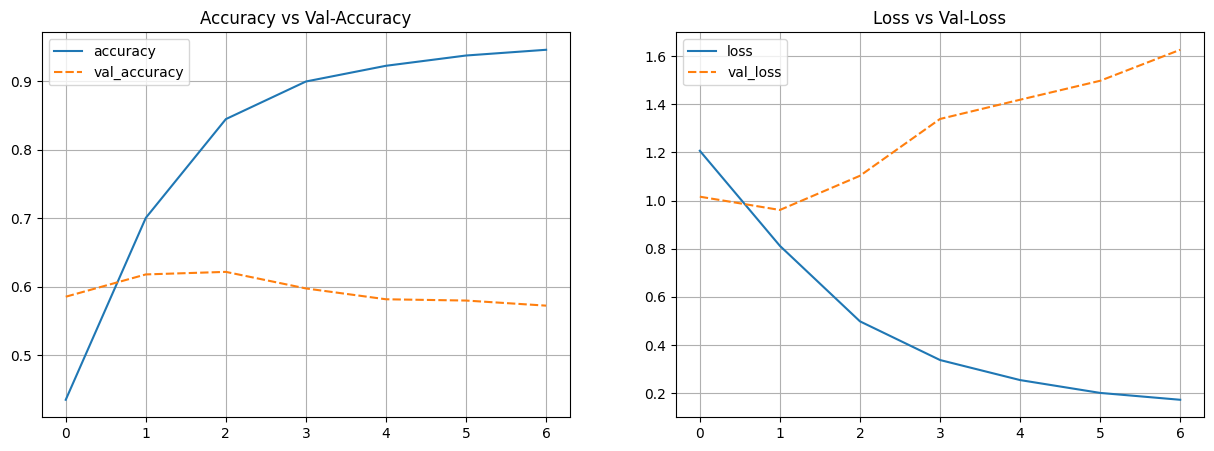

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the LSTM model training history to a DataFrame
model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

# Set up the plot size
plt.figure(figsize=(15, 5))

# Plot Accuracy vs Validation Accuracy
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

# Plot Loss vs Validation Loss
plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

# Show the plot
plt.show()


**Insight** :

Insight dari visualisasi di atas menunjukkan nilai accuracy, val_accuracy, loss, dan val_loss selama proses pelatihan model LSTM. Dengan nilai akhir sebagai berikut:

- Akurasi dan Val-Akurasi:
    - Akurasi pada data pelatihan (accuracy) mencapai sekitar 94.56%.
    - Akurasi pada data validasi (val_accuracy) mencapai sekitar 57.21%.

- Loss dan Val-Loss:
    - Loss pada data pelatihan (loss) mencapai nilai sekitar 0.1723.
    - Loss pada data validasi (val_loss) mencapai nilai sekitar 1.629.

 Model mengalami overfitting. Ini terlihat dari perbedaan yang signifikan antara performa pada data pelatihan dan data validasi. Meskipun model mampu dengan baik menggeneralisasi pada data pelatihan, performanya menurun ketika diterapkan pada data yang tidak dilihat selama pelatihan, seperti data validasi. Oleh karena itu, model ini memerlukan beberapa penyesuaian atau tindakan pencegahan overfitting, mungkin dengan menggunakan teknik seperti dropout lebih lanjut, pengurangan kompleksitas model, atau penambahan data pelatihan tambahan jika memungkinkan dan memastikan dataset memiliki jumlah sampel yang cukup dan beragam.

## C.4.4 - GRU

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Bidirectional, Dropout, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

callbacks_1 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture with GRU
model_gru_best = Sequential()
model_gru_best.add(Input(shape=(1,), dtype=tf.string)) # Add Input Layer
model_gru_best.add(text_vectorization)
model_gru_best.add(embedding)
model_gru_best.add(Bidirectional(GRU(64, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed),
                                recurrent_regularizer=regularizers.l2(0.01))))
model_gru_best.add(Dropout(0.5))
model_gru_best.add(Bidirectional(GRU(32, kernel_initializer=tf.keras.initializers.GlorotUniform(seed),
                                recurrent_regularizer=regularizers.l2(0.01))))
model_gru_best.add(Dropout(0.5))
model_gru_best.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_gru_best.add(Dropout(0.5))
model_gru_best.add(Dense(7, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

model_gru_best.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    metrics=['accuracy'])

model_gru_best.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 200)               0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 200, 128)          2145536   
                                                                 
 bidirectional (Bidirection  (None, 200, 128)          74496     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 200, 128)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                31104     
 onal)                                                           
                                                        

**Insight** :

Berikut merupakan sebuah model neural network menggunakan GRU (Gated Recurrent Unit), berikut sedikit penjelasan terkait  arsitektur model yang dibuat.
- Callback : model ini menggunakan teknik EarlyStopping sebagai callback untuk menghentikan pelatihan jika tidak terjadi perbaikan, perbaikan ini berfokus pada `val_loss` setelah 5 epoch, dan callback ini untuk memulihkan bobot terbaik dari model.
- Clear Session : Dilakukan pembersihan `tf.keras.backend.clear_session()` untuk memastikan konsistensi dari sebuah model. lalu seed diatur untuk memastikan hasil pelatihan yang di reproduksi. seed merupakan nilai awal yang digunakan untuk menginisialisasi generator angka acak.
- Arsitektur Model :
    - Model Menggunakan Sequential untuk menentukan urutan layer.
    - layer pertama adalah `text_vectorization` yang sudah dibangun sebelumnya untuk mengkonversi sebuah text menjadi representasi vektor.
    - Lalu dilayer kedua adalah `Embedding` yang mengubah vektor angka dengan dimensi 128
    - lalu 2 layer dengan GRU dengan arah `Bidirectional` dengan ukuran 64 dan 32. `Bidirectional` yang dimaksud disini adalah untuk pemrosesan urutan dalam dua arah, yang dapat membantu model dalam memahami konteks teks dengan lebih baik.
    - Dua layer Dense (fully connected) yang memiliki fungsi aktivasi 'relu', dengan dropout dan regularisasi L2, untuk memproses dan menyederhanakan fitur-fitur yang diambil dari GRU layers.
    - lalu menggunakan `Dropout` untuk menghindari terjadinya Overfit pada model
    - Lapisan terakhir adalah `Dense` dengan menggunakan activasion `Softmax` untuk klasifikasi multikelas(7Kelas). activasion `Softmax` ini merupakan suatu fungsi matematis yang digunakan di lapisan output dari model neural network untuk masalah klasifikasi multikelas.
- Model compile : model dicompile menggunakan fungsi loss `categorical_crossentropy ` untuk klasifikasi multikelas, optimizer `adam`, dengan laju pembelajaran 0.001, dan metrik akurasi.

In [ ]:
model_gru_best_hist = model_gru_best.fit(X_train,
                                   y_train_ohe,
                                   epochs=50,
                                   callbacks=callbacks_1,
                                   validation_data=(X_val, y_val_ohe))

Epoch 1/50
303/303 [==============================] - 33s 82ms/step - loss: 1.5661 - accuracy: 0.7240 - val_loss: 1.3811 - val_accuracy: 0.6093
Epoch 2/50
303/303 [==============================] - 11s 36ms/step - loss: 0.7022 - accuracy: 0.8506 - val_loss: 1.3735 - val_accuracy: 0.5981
Epoch 3/50
303/303 [==============================] - 10s 32ms/step - loss: 0.5385 - accuracy: 0.8881 - val_loss: 1.3885 - val_accuracy: 0.5805
Epoch 4/50
303/303 [==============================] - 10s 33ms/step - loss: 0.4513 - accuracy: 0.9070 - val_loss: 1.5208 - val_accuracy: 0.5795
Epoch 5/50
303/303 [==============================] - 11s 35ms/step - loss: 0.3938 - accuracy: 0.9196 - val_loss: 1.5789 - val_accuracy: 0.5628
Epoch 6/50
303/303 [==============================] - 10s 32ms/step - loss: 0.3571 - accuracy: 0.9278 - val_loss: 1.6617 - val_accuracy: 0.5526
Epoch 7/50
303/303 [==============================] - 10s 32ms/step - loss: 0.3307 - accuracy: 0.9317 - val_loss: 1.7108 - val_accuracy:

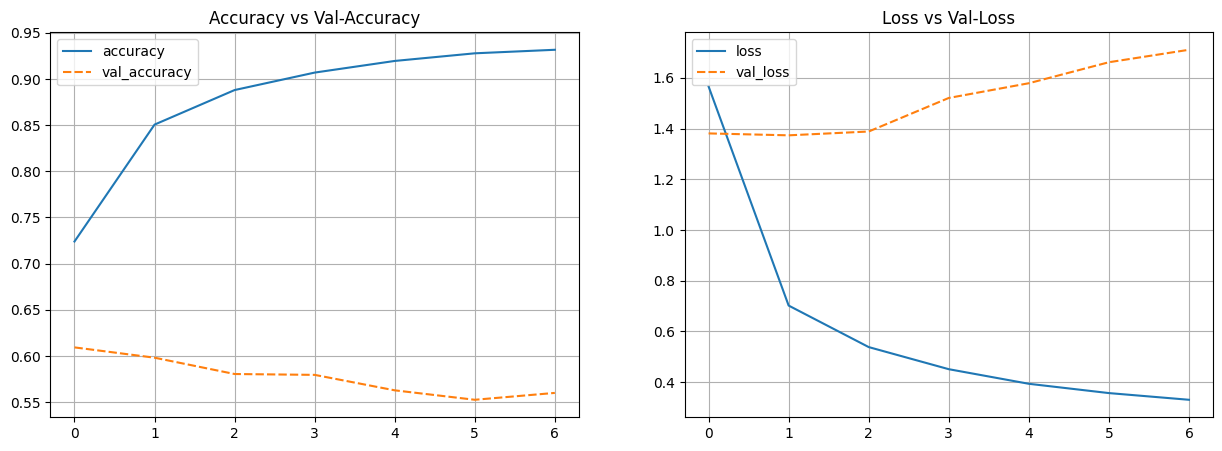

In [ ]:
# Plot Training Results

model_gru_best_hist_df = pd.DataFrame(model_gru_best_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_gru_best_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_gru_best_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

**Insight** :

Insight dari visualisasi di atas menunjukkan nilai accuracy, val_accuracy, loss, dan val_loss selama proses pelatihan model GRU. Dengan nilai akhir sebagai berikut:

- Akurasi dan Val-Akurasi:
    - Akurasi pada data pelatihan (accuracy) mencapai sekitar 93.17%.
    - Akurasi pada data validasi (val_accuracy) mencapai sekitar 56%.

- Loss dan Val-Loss:
    - Loss pada data pelatihan (loss) mencapai nilai sekitar 0.3307.
    - Loss pada data validasi (val_loss) mencapai nilai sekitar 1.7108.

 Model mengalami overfitting. Ini terlihat dari perbedaan yang signifikan antara performa pada data pelatihan dan data validasi. Meskipun model mampu dengan baik menggeneralisasi pada data pelatihan, performanya menurun ketika diterapkan pada data yang tidak dilihat selama pelatihan, seperti data validasi. Oleh karena itu, model ini memerlukan beberapa penyesuaian atau tindakan pencegahan overfitting, mungkin dengan menggunakan teknik seperti dropout lebih lanjut, pengurangan kompleksitas model, atau penambahan data pelatihan tambahan jika memungkinkan dan memastikan dataset memiliki jumlah sampel yang cukup dan beragam.

# Model LSTM With Transfer Learning

In [ ]:
# Download the Embedding Layer
import tensorflow_hub as hub

url = 'https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1'

hub_layer = tf_hub.KerasLayer(url, output_shape=[128], input_shape=[], dtype=tf.string)

**Insight** :

Transfer Learning menggunakan TensorFlow Hub. TensorFlow Hub untuk mengambil lapisan embedding dari model transfer learning teks berdimensi 128 dengan normalisasi yang telah dilatih sebelumnya
Lapisan ini diterapkan sebagai bagian dari arsitektur model, memungkinkan model memanfaatkan pengetahuan dari data teks yang luas yang telah diajarkan sebelumnya. `Hal ini dapat meningkatkan kemampuan model dalam memahami dan merepresentasikan teks`.


In [ ]:
# Model Training using LSTM with Transfer Learning

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape

callbacks_1 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_2 = Sequential()
model_lstm_2.add(hub_layer)
model_lstm_2.add(Reshape((128, 1)))
model_lstm_2.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Dense(7, activation='softmax'))

model_lstm_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm_2_hist = model_lstm_2.fit(X_train,
                                     y_train_ohe,
                                     epochs=50,
                                    callbacks=callbacks_1,
                                     validation_data=(X_val, y_val_ohe))

Epoch 1/50
303/303 [==============================] - 19s 35ms/step - loss: 1.2594 - accuracy: 0.3981 - val_loss: 1.1951 - val_accuracy: 0.4214
Epoch 2/50
303/303 [==============================] - 7s 24ms/step - loss: 1.2095 - accuracy: 0.4031 - val_loss: 1.1948 - val_accuracy: 0.4214
Epoch 3/50
303/303 [==============================] - 8s 27ms/step - loss: 1.2061 - accuracy: 0.4058 - val_loss: 1.1941 - val_accuracy: 0.4214
Epoch 4/50
303/303 [==============================] - 6s 21ms/step - loss: 1.2007 - accuracy: 0.4100 - val_loss: 1.1960 - val_accuracy: 0.4223
Epoch 5/50
303/303 [==============================] - 8s 26ms/step - loss: 1.2010 - accuracy: 0.4098 - val_loss: 1.1914 - val_accuracy: 0.4214
Epoch 6/50
303/303 [==============================] - 7s 22ms/step - loss: 1.1965 - accuracy: 0.4196 - val_loss: 1.1961 - val_accuracy: 0.4140
Epoch 7/50
303/303 [==============================] - 9s 31ms/step - loss: 1.1955 - accuracy: 0.4140 - val_loss: 1.1923 - val_accuracy: 0.421

**Insight** :

Berikut merupakan sebuah model neural network menggunakan (Long Short-Term Memory), berikut sedikit penjelasan terkait  arsitektur model yang dibuat.
- Callback : model ini menggunakan teknik EarlyStopping sebagai callback untuk menghentikan pelatihan jika tidak terjadi perbaikan, perbaikan ini berfokus pada `val_loss` setelah 5 epoch, dan callback ini untuk memulihkan bobot terbaik dari model.
- Clear Session : Dilakukan pembersihan `tf.keras.backend.clear_session()` untuk memastikan konsistensi dari sebuah model. lalu seed diatur untuk memastikan hasil pelatihan yang di reproduksi. seed merupakan nilai awal yang digunakan untuk menginisialisasi generator angka acak.
- Arsitektur Model :
    - Model Menggunakan Sequential untuk menentukan urutan layer.
    - layer pertama adalah `text_vectorization` yang sudah dibangun sebelumnya untuk mengkonversi sebuah text menjadi representasi vektor.
    - Lalu dilayer kedua adalah `Embedding` yang mengubah vektor angka dengan dimensi 128
    - lalu 2 layer dengan LSTM dengan arah `Bidirectional` dengan ukuran 32 dan 16. `Bidirectional` yang dimaksud disini adalah untuk pemrosesan urutan dalam dua arah, yang dapat membantu model dalam memahami konteks teks dengan lebih baik.
    - lalu menggunakan `Dropout` untuk menghindari terjadinya Overfit pada model
    - Lapisan terakhir adalah `Dense` dengan menggunakan activasion `Softmax` untuk klasifikasi multikelas(7Kelas). activasion `Softmax` ini merupakan suatu fungsi matematis yang digunakan di lapisan output dari model neural network untuk masalah klasifikasi multikelas.
- Model compile : model dicompile menggunakan fungsi loss `categorical_crossentropy ` untuk klasifikasi multikelas, optimizer `adam`, dan metrik akurasi.

Dengan menggunakan Transfer Learning TensorFlow Hub, model dapat memanfaatkan pengetahuan yang telah diperoleh dari model transfer learning sebelumnya, memperkaya representasi teks dan meningkatkan kemampuan model dalam tugas klasifikasi.

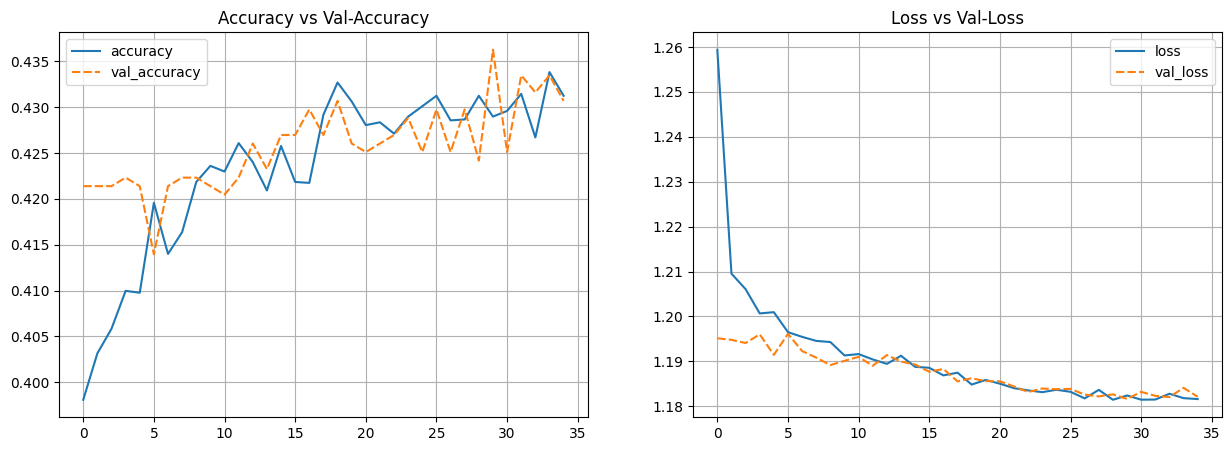

In [ ]:
# Plot Training Results

model_lstm_2_hist_hist_df = pd.DataFrame(model_lstm_2_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_2_hist_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_2_hist_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

**Insight** :

visualisasi di atas menunjukkan nilai accuracy, val_accuracy, loss, dan val_loss selama proses pelatihan model LSTM dengan memanfaatkan transfer learning. Dengan nilai akhir sebagai berikut:

- Akurasi dan Val-Akurasi:
    - Akurasi pada data pelatihan (accuracy) mencapai sekitar 43.13%.
    - Akurasi pada data validasi (val_accuracy) mencapai sekitar 43.07%.

- Loss dan Val-Loss:
    - Loss pada data pelatihan (loss) mencapai nilai sekitar 1.18.
    - Loss pada data validasi (val_loss) mencapai nilai sekitar 1.18.

Model tidak menunjukkan gejala overfitting, karena perbedaan antara akurasi pada data pelatihan dan data validasi relatif kecil, Meskipun model tidak overfitting, akurasi yang dihasilkan cenderung kecil. Hal ini dapat disebabkan oleh kompleksitas tugas klasifikasi atau kebutuhan penyesuaian lebih lanjut pada arsitektur model. Melihat akurasi yang masih terbatas, model ini dapat diperbaiki dengan menyesuaikan hyperparameter, menambahkan lapisan atau mengubah struktur arsitektur model, dan melibatkan lebih banyak data pelatihan untuk meningkatkan generalisasi. Penting untuk memastikan dataset memiliki jumlah sampel yang memadai dan beragam.

# Model Gru with Transfer Learning

In [ ]:
# Download the Embedding Layer
import tensorflow_hub as hub

url = 'https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1'

hub_layer = tf_hub.KerasLayer(url, output_shape=[128], input_shape=[], dtype=tf.string)

**Insight** :

Transfer Learning menggunakan TensorFlow Hub. TensorFlow Hub untuk mengambil lapisan embedding dari model transfer learning teks berdimensi 128 dengan normalisasi yang telah dilatih sebelumnya
Lapisan ini diterapkan sebagai bagian dari arsitektur model, memungkinkan model memanfaatkan pengetahuan dari data teks yang luas yang telah diajarkan sebelumnya. `Hal ini dapat meningkatkan kemampuan model dalam memahami dan merepresentasikan teks`.


In [ ]:
# Model Training using GRU with Transfer Learning

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape

callbacks_1 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_gru_2 = Sequential()
model_gru_2.add(hub_layer)
model_gru_2.add(Reshape((128, 1)))
model_gru_2.add(Bidirectional(GRU(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_gru_2.add(Dropout(0.1))
model_gru_2.add(Bidirectional(GRU(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_gru_2.add(Dropout(0.1))
model_gru_2.add(Dense(7, activation='softmax'))

model_gru_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_gru_2_hist = model_gru_2.fit(X_train,
                                   y_train_ohe,
                                   epochs=50,
                                   callbacks=callbacks_1,
                                   validation_data=(X_val, y_val_ohe))

Epoch 1/50
303/303 [==============================] - 16s 33ms/step - loss: 1.2694 - accuracy: 0.3973 - val_loss: 1.1952 - val_accuracy: 0.4214
Epoch 2/50
303/303 [==============================] - 7s 24ms/step - loss: 1.2046 - accuracy: 0.4057 - val_loss: 1.1930 - val_accuracy: 0.4214
Epoch 3/50
303/303 [==============================] - 7s 24ms/step - loss: 1.2016 - accuracy: 0.4132 - val_loss: 1.1908 - val_accuracy: 0.4233
Epoch 4/50
303/303 [==============================] - 7s 24ms/step - loss: 1.1955 - accuracy: 0.4210 - val_loss: 1.1926 - val_accuracy: 0.4047
Epoch 5/50
303/303 [==============================] - 7s 23ms/step - loss: 1.1950 - accuracy: 0.4161 - val_loss: 1.1881 - val_accuracy: 0.4242
Epoch 6/50
303/303 [==============================] - 7s 24ms/step - loss: 1.1920 - accuracy: 0.4259 - val_loss: 1.1926 - val_accuracy: 0.4093
Epoch 7/50
303/303 [==============================] - 6s 21ms/step - loss: 1.1901 - accuracy: 0.4228 - val_loss: 1.1900 - val_accuracy: 0.427

**Insight** :

Berikut merupakan sebuah model neural network menggunakan (Gated Recurrent Unit), berikut sedikit penjelasan terkait  arsitektur model yang dibuat.
- Callback : model ini menggunakan teknik EarlyStopping sebagai callback untuk menghentikan pelatihan jika tidak terjadi perbaikan, perbaikan ini berfokus pada `val_loss` setelah 5 epoch, dan callback ini untuk memulihkan bobot terbaik dari model.
- Clear Session : Dilakukan pembersihan `tf.keras.backend.clear_session()` untuk memastikan konsistensi dari sebuah model. lalu seed diatur untuk memastikan hasil pelatihan yang di reproduksi. seed merupakan nilai awal yang digunakan untuk menginisialisasi generator angka acak.
- Arsitektur Model :
    - Model Menggunakan Sequential untuk menentukan urutan layer.
    - layer pertama adalah `text_vectorization` yang sudah dibangun sebelumnya untuk mengkonversi sebuah text menjadi representasi vektor.
    - Lalu dilayer kedua adalah `Embedding` yang mengubah vektor angka dengan dimensi 128
    - lalu 2 layer dengan LSTM dengan arah `Bidirectional` dengan ukuran 32 dan 16. `Bidirectional` yang dimaksud disini adalah untuk pemrosesan urutan dalam dua arah, yang dapat membantu model dalam memahami konteks teks dengan lebih baik.
    - lalu menggunakan `Dropout` untuk menghindari terjadinya Overfit pada model
    - Lapisan terakhir adalah `Dense` dengan menggunakan activasion `Softmax` untuk klasifikasi multikelas(7Kelas). activasion `Softmax` ini merupakan suatu fungsi matematis yang digunakan di lapisan output dari model neural network untuk masalah klasifikasi multikelas.
- Model compile : model dicompile menggunakan fungsi loss `categorical_crossentropy ` untuk klasifikasi multikelas, optimizer `adam`, dan metrik akurasi.

Dengan menggunakan Transfer Learning TensorFlow Hub, model dapat memanfaatkan pengetahuan yang telah diperoleh dari model transfer learning sebelumnya, memperkaya representasi teks dan meningkatkan kemampuan model dalam tugas klasifikasi.

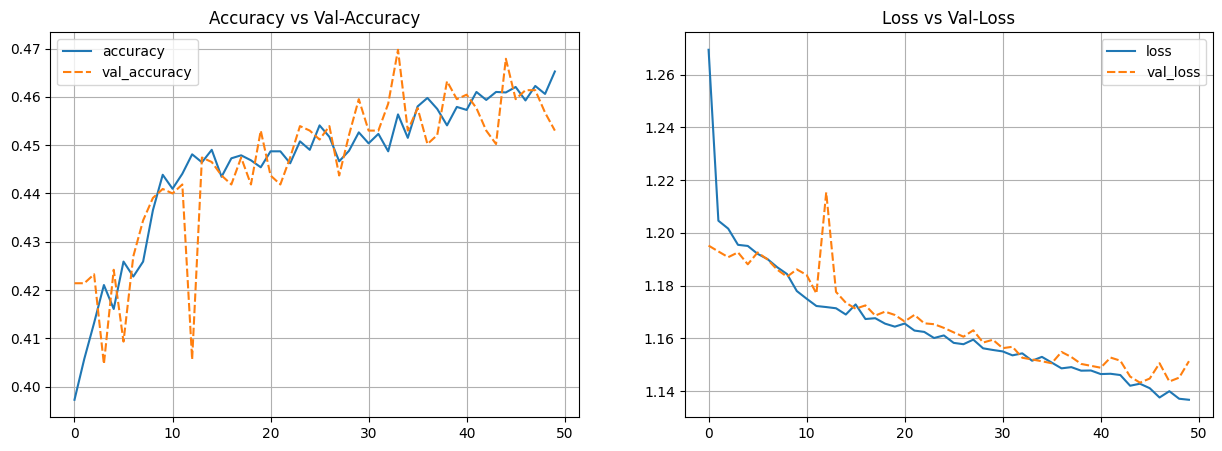

In [ ]:
# Plot Training Results

model_gru_2_hist_df = pd.DataFrame(model_gru_2_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_gru_2_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_gru_2_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

**Insight** :

visualisasi di atas menunjukkan nilai accuracy, val_accuracy, loss, dan val_loss selama proses pelatihan model GRU dengan memanfaatkan transfer learning. Dengan nilai akhir sebagai berikut:

- Akurasi dan Val-Akurasi:
    - Akurasi pada data pelatihan (accuracy) mencapai sekitar 46.53%.
    - Akurasi pada data validasi (val_accuracy) mencapai sekitar 45.30%.

- Loss dan Val-Loss:
    - Loss pada data pelatihan (loss) mencapai nilai sekitar 1.13.
    - Loss pada data validasi (val_loss) mencapai nilai sekitar 1.15.

Model tidak menunjukkan gejala overfitting, karena perbedaan antara akurasi pada data pelatihan dan data validasi relatif kecil, Meskipun model tidak overfitting, akurasi yang dihasilkan cenderung kecil. Hal ini dapat disebabkan oleh kompleksitas tugas klasifikasi atau kebutuhan penyesuaian lebih lanjut pada arsitektur model. Melihat akurasi yang masih terbatas, model ini dapat diperbaiki dengan menyesuaikan hyperparameter, menambahkan lapisan atau mengubah struktur arsitektur model, dan melibatkan lebih banyak data pelatihan untuk meningkatkan generalisasi. Penting untuk memastikan dataset memiliki jumlah sampel yang memadai dan beragam.

# Model Saving

Untuk proses saving model. model yang akan digunakan merupakan model yang dibandingkan dari model ANN training dan model ANN Improvement. karena model ANN Training mengalami overfit, maka saya memutuskan untuk menggunakan model ANN Improvement menggunakan Transferlearning walaupun akurasi tidak baik tapi model tidak mengalami overfit seperti ANN training. model yang akan di save merupakan Model GRU dengan Transferlearning.

In [ ]:
model_gru_2.save('model_gru_2', save_format='tf')
# Save ANN model


Untuk proses saving model. model yang akan digunakan merupakan model yang dibandingkan dari model ANN training dan model ANN Improvement. karena model ANN Training mengalami overfit, maka saya memutuskan untuk menggunakan model ANN Improvement menggunakan Transferlearning walaupun akurasi tidak baik tapi model tidak mengalami overfit seperti ANN training. model yang akan di save merupakan Model GRU dengan Transferlearning.

In [ ]:
model_gru_2.save('gru_model.keras')

# moodel inference

Setelah menyimpan model dalam bentuk file, kita bisa memanggilnya kembali untuk menguji bagaimana model melakukan prediksi. Ini sangat membantu untuk mengevaluasi seberapa baik model bekerja dan bagaimana kemampuannya memprediksi data baru. Dengan cara ini, kita bisa menilai seberapa akurat model dalam menghadapi situasi dunia nyata. Proses ini menjadi kunci untuk memastikan dan menguji model GRU yang sudah kita latih sebelumnya.

In [ ]:
import pandas as pd
from keras.models import load_model
import numpy as np

# Load Model
model = load_model('model_gru_2')

# Input Text
input_text = "Kamu yang terbaik"

# Make a prediction using model
predictions = model.predict(np.array([input_text]))

predicted_class = np.argmax(predictions[0])

# Map predicted class to labels
class_labels = {0: 'Netral', 1: 'Positive', 2: 'Negative',3: 'Insulting the Government or Public Agency', 4: 'Insulting or Defaming Others', 5: 'Threatening Others', 6: 'Alluding to the Tribe, Religion, Race and intergroup'}
predicted_label = class_labels[predicted_class]

# Display the results
print("Input Text:", input_text)
print("Predicted Class:", predicted_class)
print("Predicted Label:", predicted_label)
print("Prediction Probabilities:", predictions[0])

# Create a DataFrame to store the results
columns = ['Input Text', 'Predicted Class', 'Predicted Label', 'Prediction Probabilities']
data = [[input_text, predicted_class, predicted_label, predictions[0]]]
result_df = pd.DataFrame(data, columns=columns)

# Display the DataFrame
print("\nResult DataFrame:")
print(result_df)


1/1 [==============================] - 2s 2s/step
Input Text: Kamu yang terbaik
Predicted Class: 0
Predicted Label: Netral
Prediction Probabilities: [0.36162993 0.2654957  0.34402516 0.00757789 0.01032981 0.00258866
 0.00835283]

Result DataFrame:
          Input Text  Predicted Class Predicted Label  \
0  Kamu yang terbaik                0          Netral   

                            Prediction Probabilities  
0  [0.36162993, 0.2654957, 0.34402516, 0.00757788...  


**insight** :

1. Proses inferensi data bertujuan untuk menguji sejauh mana mengklasifikasikan sentimen dari teks yang diberikan, serta sejauh mana model yakin dengan prediksi yang dihasilkan menggunakan dummy data.
2. pada data inference. dummy Teks yang digunakan sebagai input untuk model adalah "`kamu yang terbaik`", Kelas yang diprediksi oleh model adalah kelas dengan nilai 1, Label yang sesuai dengan kelas yang diprediksi adalah "netral". Dalam konteks ini, kelas 1 diinterpretasikan sebagai sentimen netral. jika dilihat dari Probabilitas prediksi untuk masing-masing kelas. Dalam hal ini, model memberikan probabilitas sekitar 36.16% untuk kelas 0 (Netral), 26.54% untuk kelas 1 (Positif), dan 34.40% untuk kelas 2 (Negatif). maka dari itu model di prediksi sebagai class 0 atau Netral

Dalam eksplorasi dan pengembangan model untuk tugas klasifikasi sentimen, model yang dipilih adalah GRU (Gated Recurrent Unit) dengan memanfaatkan transfer learning menggunakan TensorFlow Hub. Berikut adalah kesimpulan dari model ini:

**A**
1. Transfer Learning dengan TensorFlow Hub:
    - Model memanfaatkan lapisan embedding dari TensorFlow Hub, yang telah dilatih sebelumnya untuk memahami representasi teks dengan lebih baik.
2. Struktur Arsitektur Model:
    - Arsitektur model GRU yang digunakan melibatkan beberapa lapisan, termasuk lapisan text_vectorization, lapisan Embedding dengan dimensi 128, dan dua lapisan GRU bidirectional untuk pemrosesan urutan yang lebih baik.
    - Teknik dropout juga diterapkan untuk mencegah overfitting pada model.
3. Pelatihan dan Evaluasi Model:
    - Model telah diinstruksikan untuk menghentikan pelatihan jika tidak terjadi perbaikan dalam val_loss setelah 5 epoch, menggunakan teknik EarlyStopping.
    - Evaluasi model dilakukan dengan melihat metrik akurasi, loss, dan visualisasi grafik akurasi dan loss selama proses pelatihan.
4. Hasil dan Performa Model:
    - Model berhasil dilatih dan dievaluasi dengan hasil yang cukup.
    - Hasil evaluasi model tidak menunjukkan tanda-tanda overfitting, namun akurasi yang dihasilkan pada data validasi cenderung terbatas/kecil.
5. Kelebihan:
    - Model dapat memanfaatkan pengetahuan yang telah diperoleh dari model transfer learning sebelumnya melalui lapisan embedding TensorFlow Hub. Hal ini membantu dalam memahami konteks dan merepresentasikan teks dengan lebih kaya, dan mampung menghindari dari overfitting.
6. Kelemahan:
    - Akurasi Terbatas pada Data Validasi :
        - Meskipun model tidak menunjukkan gejala overfitting, akurasi pada data validasi masih terbatas. Ini mungkin memerlukan penyesuaian lebih lanjut pada hyperparameter atau struktur model untuk meningkatkan kinerja.
    - Keterbatasan pada Jumlah Data Pelatihan:
        - Kinerja model dapat dipengaruhi oleh jumlah data pelatihan yang terbatas. Penambahan data pelatihan tambahan dapat membantu dalam meningkatkan generalisasi model.
7. Batasan:
    - Data Pelatihan Terbatas:
        - Jumlah sampel yang kurang dapat menyulitkan model untuk memahami variasi yang mungkin terjadi di lingkungan produksi.
    
**B**
Dari hasil prediksi model yang telah dibangun dan dilatih, dapat disimpulkan bahwa model memprediksi sentiment dengan nilai `0`, dummy Teks yang digunakan sebagai input untuk model adalah "`kamu yang terbaik`" yang artinya bahwa text yang tulis menandakan sentiment `Netral`